# Capstone Data Analysis

This is the python notebook for the capstone project data analysis. First, we start by importing all the required data.

In [1]:
# Import statements below
import numpy as np
import scipy as sci
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.interpolate import interp1d

In [2]:
# time, r, theta, omega, alpha = np.loadtxt('5dg28cm.txt', dtype = float, delimiter = ",", skiprows = 5, usecols = (0, 3, 13, 15), unpack = True)
set1 = pd.read_csv('5dg28cm.txt', skiprows = 1)
set1 = set1.set_axis(['t', 'x', 'y', 'r', 'thetar', 'vx', 'vy', 'v', 'thetav', 'ax', 'ay', 'a', 'thetaa',
       'θ', 'w', 'alpha', 'step', 'frame', 'px', 'py', 'p', 'thetap', 'pixelx','pixely', 'L', 'K', 'Unnamed: 26'], axis=1, inplace=False)

set2 = pd.read_csv('10dg28cm.txt', skiprows = 1)
set2 = set2.set_axis(['t', 'x', 'y', 'r', 'thetar', 'vx', 'vy', 'v', 'thetav', 'ax', 'ay', 'a', 'thetaa',
       'θ', 'w', 'alpha', 'step', 'frame', 'px', 'py', 'p', 'thetap', 'pixelx','pixely', 'L', 'K', 'Unnamed: 26'], axis=1, inplace=False)


set3 = pd.read_csv('20dg28cm.txt', skiprows = 1)
set3 = set3.set_axis(['t', 'x', 'y', 'r', 'thetar', 'vx', 'vy', 'v', 'thetav', 'ax', 'ay', 'a', 'thetaa',
       'θ', 'w', 'alpha', 'step', 'frame', 'px', 'py', 'p', 'thetap', 'pixelx','pixely', 'L', 'K', 'Unnamed: 26'], axis=1, inplace=False)

In [3]:
def parplot(df, angle):
    plt.plot(df['x'], df['y'])
    plt.title(r"Parametric Plot of Position ($\theta_0$="+f"{angle}deg)")
    plt.xlabel(r'X Position, $x$ (m)')
    plt.ylabel(r'Y Position, $y$ (m)')

In [4]:
bruh1 = pd.read_csv('5dg28cm.txt', skiprows=1)
bruh2 = pd.read_csv('10dg28cm.txt', skiprows=1)
bruh3 = pd.read_csv('20dg28cm.txt', skiprows=1)

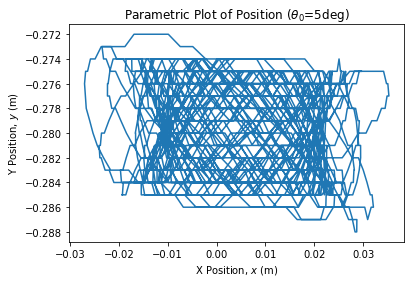

In [5]:
parplot(bruh1, 5)

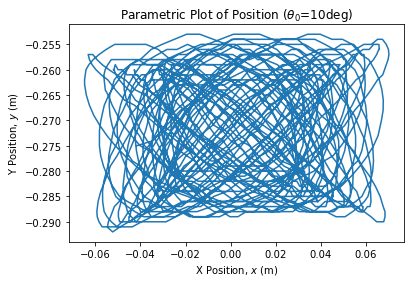

In [6]:
parplot(bruh2, 10)

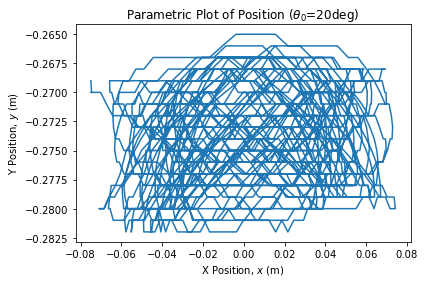

In [7]:
parplot(bruh3, 20)

Now that we have all the fits, we can plot $x$ and $y$ for a parametric plot. We chose data set 1 just for illustration purposes. 

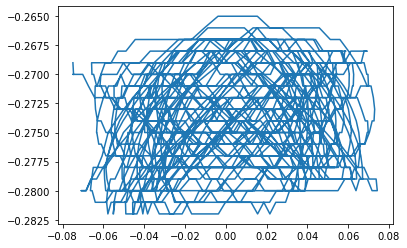

In [8]:
plt.plot(set3['x'], set3['y'])
plt.show()

## Taking numerical derivatives 

We need fit the data to the following differential equation:

$$\ddot \theta = \dfrac{g}{l_0 + x} \sin \theta - \dfrac{2 \dot x}{l_0 + x} \dot \theta$$

In the way that we generated the data, we set $l_0 + x = r$, so our equation simplifies to:

$$\ddot \theta = \dfrac{g}{r} \sin \theta - \dfrac{2 \dot x}{r} \dot \theta$$

Since our goal here is to get an experimental value for $g$, then it means that we need all the other values. Some of this data (like $r$) are already given to us from the data, but others (like $\dot \theta$) we'll need to calculate by taking a numerical derivative. We've already done this in a previous experiment, so I won't really be going into too much detail here. The general idea is as follows:

To take the derivative experimentally, it's better to take the change from element $i$ to element $i + 2$ as opposed to element $i$ and $i + 1$, so that our derivatife corresopnds to the time points that we have. This isn't really that much of an issue becuase the time scale that we're using is so small that a single offset won't really change that much, but this is still important to note. Below is a function that calculates the centered differences to calculate the derivative:

In [9]:
def centered_dy(y, x):
    '''
        Uses centered differences (see below) to estimate the derivatives at each value of x, 
        except for the first and last values. The derivative at the first value of x is estimated 
        using a forward difference. The derivative at the last value of x is estimated 
        using a backward difference.
            dy/dx at x[i] is approximated by (y[i+1] - y[i-1]) / (x[i+1]-x[i-1])
    '''
    dyc = [0.0]*len(x)
    dyc[0] = (y[0] - y[1])/(x[0] - x[1])
    for i in range(1,len(y)-1):
        dyc[i] = (y[i+1] - y[i-1])/(x[i+1]-x[i-1])
    dyc[-1] = (y[-1] - y[-2])/(x[-1] - x[-2])

    return dyc

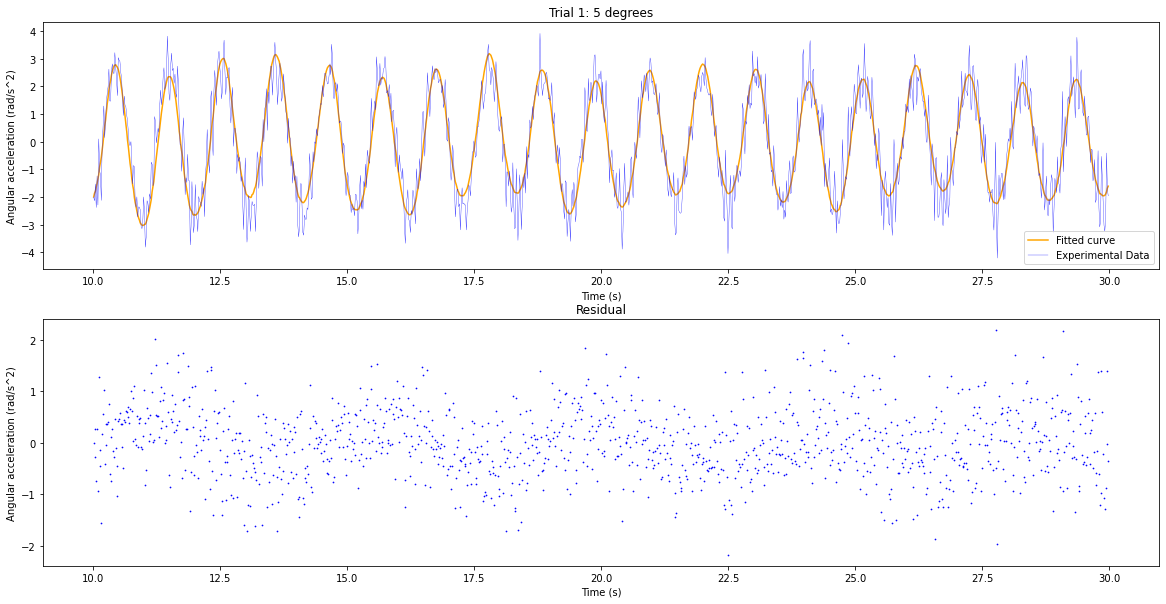

Fitted parameters (g, c respectively): [-9.7891991   0.76694381]
Errors: [0.11005615 0.02053623]


In [10]:
# Use the bounds that are in between the starting and endpoint, so we don't record the effects of our hand starting and stopping the experiment.
set1 = set1[set1['t'] > 10.0]
set1 = set1[set1['t'] < 30.0]

set2 = set2[set2['t'] > 10.0]
set2 = set2[set2['t'] < 30.0]

set3 = set3[set3['t'] > 10.0]
set3 = set3[set3['t'] < 30.0]

dx_dt1 = np.array(centered_dy(np.array(set1['x']),np.array(set1['t'])))
dx_dt2 = np.array(centered_dy(np.array(set2['x']),np.array(set2['t'])))
dx_dt3 = np.array(centered_dy(np.array(set3['x']),np.array(set3['t'])))

def fit (X, g, c):
    theta, omega, r, dx_dt = X
    omega = 2*np.pi/360 * omega
    theta = 2*np.pi/360 * (theta+90)
    return (g/r*np.sin(theta) - (2*dx_dt)/r*omega)+c

def plots(set, name, dxdt):
    opt1, cov = opt.curve_fit(fit, [np.array(set['thetar']), np.array(set['w']), np.array(set['r']), dxdt], np.array(set['alpha'])*np.pi/180, p0 = (-1000, 0))

    cov = np.sqrt(np.diag(cov))

    fig, axes = plt.subplots(2, figsize = (20, 10))

    axes[0].plot(set['t'], fit([np.array(set['thetar']), np.array(set['w']), np.array(set['r']),dxdt],*opt1), c = 'orange', label = "Fitted curve")
    axes[0].plot(set['t'], set['alpha']*np.pi/180, c = 'blue', linewidth = 0.3, label = "Experimental Data")
    axes[0].set_title(name)
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Angular acceleration (rad/s^2)")
    axes[0].legend()

    residual = set['alpha']*np.pi/180 - fit([np.array(set['thetar']), np.array(set['w']), np.array(set['r']),dxdt],*opt1)
    axes[1].scatter(set['t'], residual, c = 'blue', s = 0.5)
    axes[1].set_title("Residual")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Angular acceleration (rad/s^2)")
    plt.show()
    print(f"Fitted parameters (g, c respectively): {opt1}")
    print(f"Errors: {cov}")


plots(set1, "Trial 1: 5 degrees", dx_dt1)
# plt.plot(set1['t'],set1['alpha']*np.pi/180, c = 'blue')
# plt.plot(set1['t'],fit([np.array(set1['thetar']), np.array(set1['w']), np.array(set1['r']),dx_dt1],-9.8,0), c = 'orange')
# print(len(dx_dt1))
# print(len(set1['w']))
# print(a)
# fit([np.array(set1['thetar']), np.array(set1['w']), np.array(set1['r']),dx_dt1],*a)
# print(a)

Now we plot the other values as well:

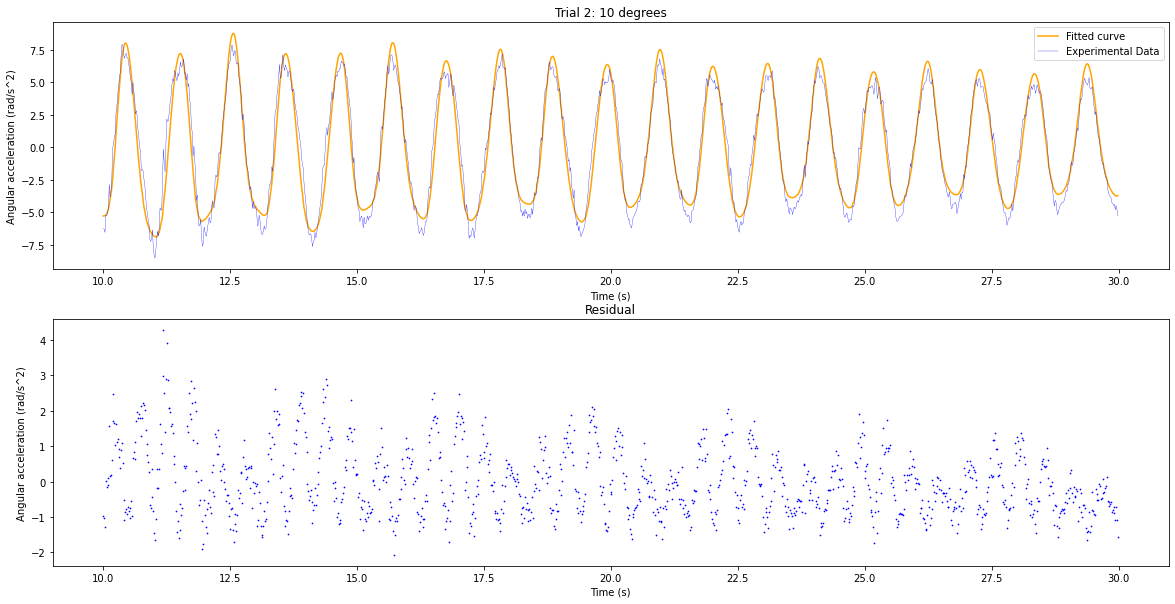

Fitted parameters (g, c respectively): [-9.80053567  1.49422122]
Errors: [0.06457474 0.02807361]


In [11]:
plots(set2, "Trial 2: 10 degrees", dx_dt2)

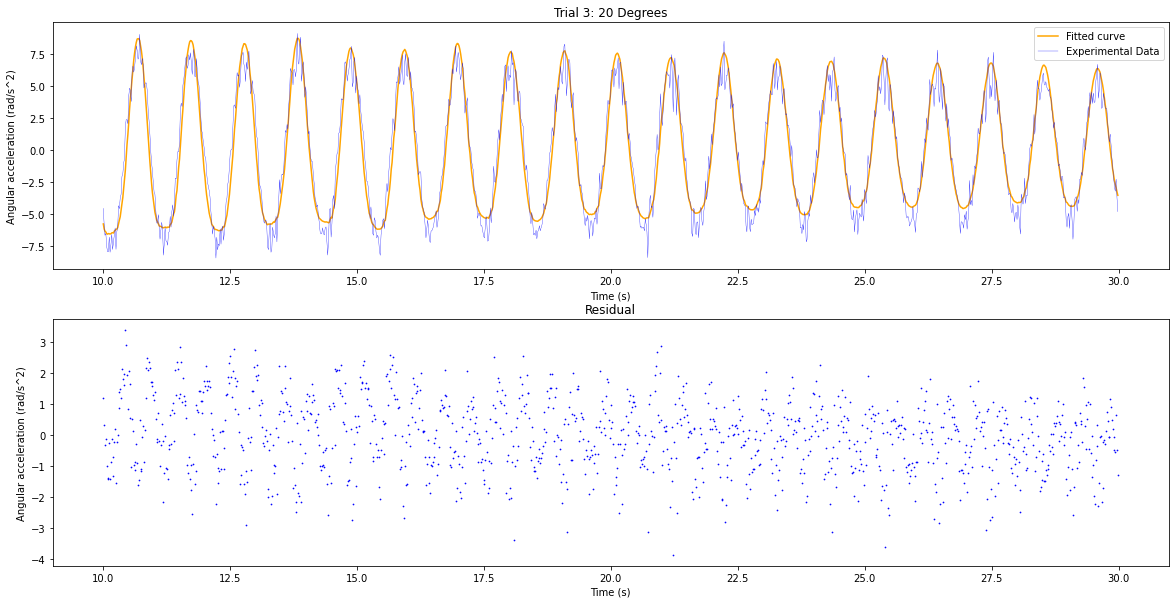

Fitted parameters (g, c respectively): [-9.9775928   1.60346275]
Errors: [0.07306353 0.03388218]


In [12]:
plots(set3, "Trial 3: 20 Degrees", dx_dt3)